### imports

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from ml1_mnist.knn import KNNClassifier
from ml1_mnist.preprocessing import StandardScaler
from ml1_mnist.feature_selection import VarianceThreshold
from ml1_mnist.model_selection import TrainTestSplitter, GridSearchCV
from ml1_mnist.metrics import (accuracy_score,
                               zero_one_loss, 
                               confusion_matrix, 
                               plot_confusion_matrix)
from ml1_mnist.utils import Stopwatch, RNG
from ml1_mnist.utils.dataset import (load_mnist, 
                                     plot_mnist_digit)
from ml1_mnist.utils.read_write import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load dataset

In [47]:
X, y = load_mnist(mode='train', path='data/')
X.shape

(60000, 784)

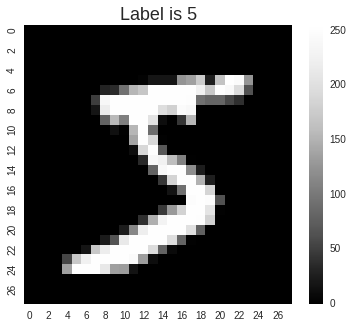

In [3]:
plot_mnist_digit(X[0], y[0]);

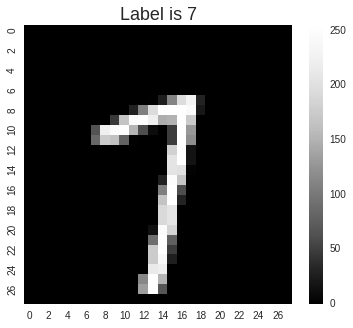

In [4]:
plot_mnist_digit(X[42], y[42]);

# k-NN

## Approach #1: remove (almost) constant features + standartize + (non-kernelized) k-NN

### Scale data to [0, 1] range

In [53]:
X_scaled = X / 255.
print X_scaled.min(), X_scaled.max()
print X_scaled.shape

0.0 1.0
(60000, 784)


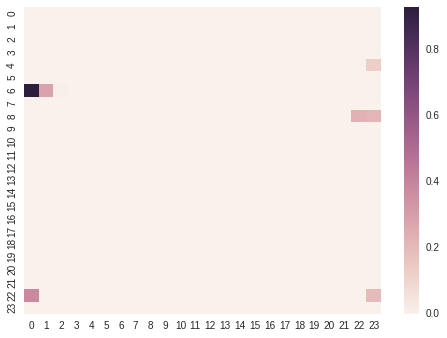

In [6]:
sns.heatmap(X_scaled[100:124, 100:124]); # lots of zeros ofc

### Remove features with low variance (784 -> 444)

In [54]:
X_scaled = VarianceThreshold(0.1).fit_transform(X_scaled)
print X_scaled.min(), X_scaled.max()
print X_scaled.shape

0.0 1.0
(60000, 444)


### Now perform mean-std standartization

In [55]:
X_scaled = StandardScaler(copy=False).fit_transform(X_scaled)
print X_scaled.min(), X_scaled.max()
print X_scaled.shape

-1.27420789208 9.7871062278
(60000, 444)


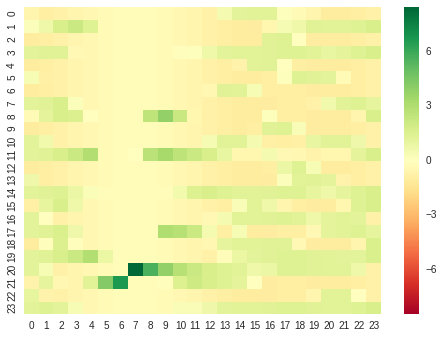

In [9]:
sns.heatmap(X_scaled[100:124, 100:124], cmap='RdYlGn'); # more interesting

### Some benchmarks
As you can see, for brute-force algorithm no training time needed at all, but longer prediction, compared to k-d tree. The difference become bigger as number of training samples grows and it should be even bigger when we'll use much less number of features after PCA (now 444).

In [20]:
knn = KNNClassifier(algorithm='brute')
knn

KNNClassifier(algorithm='brute', degree=3, gamma='auto', k=5, kd_tree_=None,
       kernel=None, leaf_size=30, p=2.0, weights='uniform')

In [21]:
with Stopwatch(verbose=True) as s:
    knn.fit(X_scaled[:1000], y[:1000])

Elapsed time: 0.000 sec


In [22]:
with Stopwatch(True) as s:
    y_pred = knn.predict(X_scaled[1000:1100])
print zero_one_loss(y_pred, y[1000:1100])

Elapsed time: 2.010 sec
0.21


In [23]:
knn2 = KNNClassifier(algorithm='kd_tree', leaf_size=10)
knn2

KNNClassifier(algorithm='kd_tree', degree=3, gamma='auto', k=5, kd_tree_=None,
       kernel=None, leaf_size=10, p=2.0, weights='uniform')

In [24]:
with Stopwatch(True) as s:
    knn2.fit(X_scaled[:1000], y[:1000])

Elapsed time: 0.432 sec


In [25]:
with Stopwatch(True) as s:
    y_pred = knn2.predict(X_scaled[1000:1100])
print zero_one_loss(y_pred, y[1000:1100])

Elapsed time: 0.417 sec
0.21


### GridSearchCV (uses stratified K-Fold CV)
This class will be used for convenient hyper-parameters grid search for simple models. This class desing as many others is inspired by one of `sklearn`, yet have some extensions (such as model saving, that is supported for all models here, and possibility to specify order for parameters exploration). 

One more feature is the following -- parameter `refit`, which controls order of exploring parameters. 

If set to `True`, then for each combination of parameters we refit our model for each new train/test split to get mean accuracy score for given set of parameters as soon as possible. This makes sense for each ML algorithm (typically parametric), with explicit training procedure.

If set to `False`, then for each possible split we fit our model **once**, and after that we evaluate this model on all possible combination of parameters. This makes sense and yields results **significantly** faster for such models (typically non-parametric), as k-NN, in particular.

Below small demo of output for `refit`=True:

In [ ]:
param_grid = ({'weights': ['uniform', 'distance'], 'k': [2, 3]}, {'p': [1., np.inf], 'k': [2]})
grid_cv1 = GridSearchCV(model=KNNClassifier(algorithm='kd_tree', leaf_size=1), param_grid=param_grid, 
                        train_test_splitter_params=dict(shuffle=True, random_seed=1337), n_splits=4, 
                        refit=True, save_models=False, verbose=True)
grid_cv1.fit(X_scaled[:1000], y[:1000]); # rebuilding tree on each iteration

# Training KNNClassifier on 1000 samples x 444 features.
# 4-fold CV for each of 6 params combinations == 24 fits ...

# iter:  1/24 +--- elapsed:   1.026 sec   ...
# iter:  2/24 ++-- elapsed:   2.022 sec   ...
# iter:  3/24 +++- elapsed:   3.010 sec   ...
# iter:  4/24 ++++ elapsed:   4.012 sec - mean acc.: 0.7940 +/- 2 * 0.038
# iter:  5/24 +--- elapsed:   5.017 sec - best acc.: 0.7940 at {'k': 2, 'weights': 'uniform'}
# iter:  6/24 ++-- elapsed:   6.017 sec - best acc.: 0.7940 at {'k': 2, 'weights': 'uniform'}
# iter:  7/24 +++- elapsed:   7.042 sec - best acc.: 0.7940 at {'k': 2, 'weights': 'uniform'}
# iter:  8/24 ++++ elapsed:   8.054 sec - mean acc.: 0.8070 +/- 2 * 0.029
# iter:  9/24 +--- elapsed:   9.093 sec - best acc.: 0.8070 at {'k': 2, 'weights': 'distance'}
# iter: 10/24 ++-- elapsed:  10.105 sec - best acc.: 0.8070 at {'k': 2, 'weights': 'distance'}
# iter: 11/24 +++- elapsed:  11.138 sec - best acc.: 0.8070 at {'k': 2, 'weights': 'distance'}
# iter: 12/24 ++++ elapsed:  12.157 sec - mean acc.: 0.8209 +/- 2 * 0.024
# iter: 13/24 +--- elapsed:  13.198 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 14/24 ++-- elapsed:  14.308 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 15/24 +++- elapsed:  15.596 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 16/24 ++++ elapsed:  16.607 sec - mean acc.: 0.7811 +/- 2 * 0.029
# iter: 17/24 +--- elapsed:  17.706 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 18/24 ++-- elapsed:  18.770 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 19/24 +++- elapsed:  19.840 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 20/24 ++++ elapsed:  20.889 sec - mean acc.: 0.8140 +/- 2 * 0.031
# iter: 21/24 +--- elapsed:  21.866 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 22/24 ++-- elapsed:  22.843 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 23/24 +++- elapsed:  23.811 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 24/24 ++++ elapsed:  24.766 sec - mean acc.: 0.4880 +/- 2 * 0.018

and for `refit`=True: (difference is not big because too many features and too few parameter combinations are used)

In [ ]:
grid_cv2 = GridSearchCV(model=KNNClassifier(algorithm='kd_tree', leaf_size=1), param_grid=param_grid, 
                        train_test_splitter_params=dict(shuffle=True, random_seed=1337), n_splits=4, 
                        refit=False, save_models=False, verbose=True)
grid_cv2.fit(X_scaled[:1000], y[:1000]); # building tree only on each 6-th iteration

# Training KNNClassifier on 1000 samples x 444 features.
# 4-fold CV for each of 6 params combinations == 24 fits ...

# iter:  1/24 +--- elapsed:   1.019 sec - best acc.: 0.8110  [1/4 splits] at {'k': 2, 'weights': 'uniform'}
# iter:  2/24 +--- elapsed:   1.834 sec - best acc.: 0.8228  [1/4 splits] at {'k': 2, 'weights': 'distance'}
# iter:  3/24 +--- elapsed:   2.645 sec - best acc.: 0.8386  [1/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter:  4/24 +--- elapsed:   3.448 sec - best acc.: 0.8386  [1/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter:  5/24 +--- elapsed:   4.277 sec - best acc.: 0.8386  [1/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter:  6/24 +--- elapsed:   5.058 sec - best acc.: 0.8386  [1/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter:  7/24 ++-- elapsed:   6.073 sec - best acc.: 0.8055  [2/4 splits] at {'k': 2, 'weights': 'uniform'}
# iter:  8/24 ++-- elapsed:   6.878 sec - best acc.: 0.8174  [2/4 splits] at {'k': 2, 'weights': 'distance'}
# iter:  9/24 ++-- elapsed:   7.672 sec - best acc.: 0.8353  [2/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 10/24 ++-- elapsed:   8.475 sec - best acc.: 0.8353  [2/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 11/24 ++-- elapsed:   9.336 sec - best acc.: 0.8353  [2/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 12/24 ++-- elapsed:  10.125 sec - best acc.: 0.8353  [2/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 13/24 +++- elapsed:  11.311 sec - best acc.: 0.7806  [3/4 splits] at {'k': 2, 'weights': 'uniform'}
# iter: 14/24 +++- elapsed:  12.127 sec - best acc.: 0.7980  [3/4 splits] at {'k': 2, 'weights': 'distance'}
# iter: 15/24 +++- elapsed:  12.918 sec - best acc.: 0.8166  [3/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 16/24 +++- elapsed:  13.722 sec - best acc.: 0.8166  [3/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 17/24 +++- elapsed:  14.576 sec - best acc.: 0.8166  [3/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 18/24 +++- elapsed:  15.538 sec - best acc.: 0.8166  [3/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 19/24 ++++ elapsed:  16.519 sec - best acc.: 0.7940 +/- 2 * 0.038 at {'k': 2, 'weights': 'uniform'}
# iter: 20/24 ++++ elapsed:  17.322 sec - best acc.: 0.8070 +/- 2 * 0.029 at {'k': 2, 'weights': 'distance'}
# iter: 21/24 ++++ elapsed:  18.106 sec - best acc.: 0.8209 +/- 2 * 0.024 at {'k': 3, 'weights': 'uniform'}
# iter: 22/24 ++++ elapsed:  19.095 sec - best acc.: 0.8209 +/- 2 * 0.024 at {'k': 3, 'weights': 'uniform'}
# iter: 23/24 ++++ elapsed:  19.933 sec - best acc.: 0.8209 +/- 2 * 0.024 at {'k': 3, 'weights': 'uniform'}
# iter: 24/24 ++++ elapsed:  20.688 sec - best acc.: 0.8209 +/- 2 * 0.024 at {'k': 3, 'weights': 'uniform'}

best model as well as other "best" stuff are available:

In [28]:
grid_cv2.best_model_

KNNClassifier(algorithm='kd_tree', degree=3, gamma='auto', k=2,
       kd_tree_=<scipy.spatial.ckdtree.cKDTree object at 0x7f3af36af370>,
       kernel=None, leaf_size=1, p=inf, weights='uniform')

finally all results can be converted to `pandas.DataFrame` and stored to excel or whatever. For more see docstrings in code.

In [38]:
df = grid_cv2.to_df()
df.to_excel('test.xlsx')
df

,mean_score,param_k,param_p,param_weights,params,split0_score,split0_test_time,split0_train_time,split1_score,split1_test_time,split1_train_time,split2_score,split2_test_time,split2_train_time,split3_score,split3_test_time,split3_train_time,std_score
0,0.793989,2.0,,uniform,"{u'k': 2, u'weights': u'uniform'}",0.811024,0.788176,0.227173,0.800,0.815784,0.198269,0.730924,0.971021,0.213211,0.834008,0.763308,0.215292,0.038422
1,0.806970,2.0,,distance,"{u'k': 2, u'weights': u'distance'}",0.822835,0.813209,0.000000,0.812,0.802554,0.000000,0.759036,0.814196,0.000000,0.834008,0.800911,0.000000,0.028748
2,0.820927,3.0,,uniform,"{u'k': 3, u'weights': u'uniform'}",0.838583,0.808561,0.000000,0.832,0.792252,0.000000,0.779116,0.789673,0.000000,0.834008,0.782114,0.000000,0.024257
3,0.781058,3.0,,distance,"{u'k': 3, u'weights': u'distance'}",0.779528,0.801350,0.000000,0.796,0.801217,0.000000,0.734940,0.802178,0.000000,0.813765,0.986306,0.000000,0.029250
4,0.813951,2.0,1,,"{u'p': 1.0, u'k': 2}",0.838583,0.826364,0.000000,0.804,0.859847,0.000000,0.767068,0.852113,0.000000,0.846154,0.835757,0.000000,0.031388
5,0.488007,2.0,inf,,"{u'p': inf, u'k': 2}",0.484252,0.778965,0.000000,0.512,0.786770,0.000000,0.461847,0.960465,0.000000,0.493927,0.752475,0.000000,0.018091


## 5-Fold CV on 5k images!

In [51]:
param_grid = {'weights': ['uniform', 'distance'], 
              'k': range(2, 31),
              'p': [1., 2., 3., np.inf]}
param_order = ['k', 'weights', 'p']
grid_cv_knn_1 = GridSearchCV(model=KNNClassifier(algorithm='kd_tree', leaf_size=10), 
                             param_grid=param_grid,
                             param_order=param_order,
                             train_test_splitter_params=dict(shuffle=True, random_seed=1337), 
                             n_splits=5, 
                             refit=False, 
                             save_models=True,
                             dirpath='cv_models/',
                             save_params=dict(
                                 params_mask=dict(kd_tree_=False), # do not save tree
                                 json_params=dict(indent=4)),
                             verbose=True)

In [13]:
[params for params in grid_cv_knn_1.gen_params()][:10]

[{'k': 2, 'p': 1.0, 'weights': 'uniform'},
 {'k': 2, 'p': 1.0, 'weights': 'distance'},
 {'k': 2, 'p': 2.0, 'weights': 'uniform'},
 {'k': 2, 'p': 2.0, 'weights': 'distance'},
 {'k': 2, 'p': 3.0, 'weights': 'uniform'},
 {'k': 2, 'p': 3.0, 'weights': 'distance'},
 {'k': 2, 'p': inf, 'weights': 'uniform'},
 {'k': 2, 'p': inf, 'weights': 'distance'},
 {'k': 3, 'p': 1.0, 'weights': 'uniform'},
 {'k': 3, 'p': 1.0, 'weights': 'distance'}]

In [14]:
grid_cv_knn_1.number_of_combinations()

232

In [57]:
tts = TrainTestSplitter(shuffle=True, random_seed=1337)
indices, _ = tts.split(y, train_ratio=5000./60000., stratify=True)
X_knn_small = X_scaled[indices]
y_knn_small = y[indices]

In [ ]:
grid_cv_knn_1.fit(X_knn_small, y_knn_small);

# Training KNNClassifier on 4994 samples x 444 features.
# 5-fold CV for each of 232 params combinations == 1160 fits ...

# iter:    1/1160 +---- elapsed:  34.320 sec - best acc.: 0.9084  [1/5 splits] at {'p': 1.0, 'k': 2, 'weights': 'uniform'}
# iter:    2/1160 +---- elapsed:  49.252 sec - best acc.: 0.9203  [1/5 splits] at {'p': 1.0, 'k': 2, 'weights': 'distance'}
# iter:    3/1160 +---- elapsed:  63.681 sec - best acc.: 0.9203  [1/5 splits] at {'p': 1.0, 'k': 2, 'weights': 'distance'}
# ...
# iter:  925/1160 ++++- elapsed: 20728.7 sec - best acc.: 0.9217  [4/5 splits] at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter:  926/1160 ++++- elapsed: 20780.0 sec - best acc.: 0.9217  [4/5 splits] at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter:  927/1160 ++++- elapsed: 20794.5 sec - best acc.: 0.9217  [4/5 splits] at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter:  928/1160 ++++- elapsed: 20809.0 sec - best acc.: 0.9217  [4/5 splits] at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter:  929/1160 +++++ elapsed: 20843.3 sec - best acc.: 0.9091 +/- 2 * 0.007 at {'p': 1.0, 'k': 2, 'weights': 'uniform'}
# iter:  930/1160 +++++ elapsed: 20858.1 sec - best acc.: 0.9195 +/- 2 * 0.003 at {'p': 1.0, 'k': 2, 'weights': 'distance'}
# iter:  931/1160 +++++ elapsed: 20872.5 sec - best acc.: 0.9195 +/- 2 * 0.003 at {'p': 1.0, 'k': 2, 'weights': 'distance'}
# ...
# iter: 1158/1160 +++++ elapsed: 27924.2 sec - best acc.: 0.9209 +/- 2 * 0.004 at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter: 1159/1160 +++++ elapsed: 27939.9 sec - best acc.: 0.9209 +/- 2 * 0.004 at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter: 1160/1160 +++++ elapsed: 27955.6 sec - best acc.: 0.9209 +/- 2 * 0.004 at {'p': 1.0, 'k': 3, 'weights': 'uniform'}

In [59]:
df = grid_cv_knn_1.to_df()
df.to_excel('knn_1_full.xlsx')
df.sort_values(by='mean_score', ascending=False).head(10).to_excel('knn_1_best.xlsx')